# GWExPy FrequencySeries 新機能チュートリアル

`gwexpy` の `FrequencySeries` および `FrequencySeriesMatrix` は、`gwpy` の周波数領域データ処理機能を拡張し、制御工学との連携や高度な解析を可能にします。
このノートブックでは、以下の新機能を紹介します。

1. **FrequencySeriesMatrix**: 多チャンネル周波数データの効率的処理
2. **位相・群遅延解析**: `phase`, `angle`, `degree`, `group_delay`
3. **制御工学連携**: Python Control Systems Library (`control`) との相互運用

In [1]:
import sys
from pathlib import Path

# Allow `import gwexpy` when running this notebook from `examples/`.
cwd = Path.cwd().resolve()
for p in [cwd, *cwd.parents]:
    if (p / "gwexpy").is_dir():
        p_str = str(p)
        if p_str not in sys.path:
            sys.path.insert(0, p_str)
        break

import numpy as np
from astropy import units as u
from gwexpy.frequencyseries import FrequencySeries, FrequencySeriesMatrix

# 乱数シード固定
np.random.seed(42)

## 1. FrequencySeriesMatrix: 多チャンネル周波数データ

`FrequencySeriesMatrix` を使うと、多数の周波数スペクトルや伝達関数を一括管理できます。

In [2]:
# サンプルデータ生成
n_channels = 2
n_freqs = 100
df = 1.0 * u.Hz
frequencies = np.arange(n_freqs) * df.value

# 複素数データ (振幅と位相を持つと想定)
amplitude = np.random.rand(n_channels, 1, n_freqs)
phase = np.random.uniform(-np.pi, np.pi, size=(n_channels, 1, n_freqs))
data_complex = amplitude * np.exp(1j * phase)

# FrequencySeriesMatrix 作成
fsm = FrequencySeriesMatrix(
    data_complex,
    f0=0 * u.Hz,
    df=df,
    unit="V",
    channel_names=["CH_A", "CH_B"]
)

print("FrequencySeriesMatrix Summary:")
print(fsm)
print("Shape:", fsm.shape)

FrequencySeriesMatrix Summary:
SeriesMatrix(shape=(2, 1, 100),  name='')
  epoch   : 0.0
  x0      : 0.0 Hz
  dx      : 1.0 Hz
  xunit   : Hz
  samples : 100

[ Row metadata ]
     name channel unit
key                   
row0                  
row1                  

[ Column metadata ]
     name channel unit
key                   
col0                  

[ Elements metadata ]
  unit  name channel  row  col
0    V  None    None    0    0
1    V  None    None    1    0
Shape: (2, 1, 100)


## 2. 位相と群遅延の解析

`FrequencySeries` クラスには、位相 (`phase`, `angle`) や群遅延 (`group_delay`) を計算する便利なメソッドが追加されています。

In [3]:
# 単一チャンネルを取り出す
fs = fsm[0, 0]

# 位相の計算 (ラジアン)
phi = fs.phase(unwrap=True)
print("\nUnwrapped Phase (rad) at 10Hz:", phi.value[10])

# 位相の計算 (度)
deg = fs.degree(unwrap=True)
print("Unwrapped Phase (deg) at 10Hz:", deg.value[10])

# 群遅延 (Group Delay) の計算
# Group Delay = -d(phi)/d(omega)
gd = fs.group_delay()
print("\nGroup Delay (s) at 10Hz:", gd.value[10])


Unwrapped Phase (rad) at 10Hz: 6.589388736490904
Unwrapped Phase (deg) at 10Hz: 377.544164171971

Group Delay (s) at 10Hz: -0.26554357313759724


## 3. Python Control Library との連携

制御工学の分野で標準的な `control` ライブラリの **Frequency Response Data (FRD)** オブジェクトと相互変換が可能です。
これにより、GWExPyで計測した伝達関数を、制御系の設計や解析に直接利用できます。


--- Converted to Control FRD ---
<FrequencyResponseData>: sys[0]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

Freq [rad/s]  Response
------------  ---------------------
       0.000       0.235   +0.2916j
       6.283     -0.8209   -0.4795j
      12.566     -0.3859    -0.622j
      18.850     -0.4811   +0.3563j
      25.133      0.1224  +0.09673j
      31.416     -0.1557 -0.009009j
      37.699    -0.04667  -0.03457j
      43.982      0.4479   +0.7414j
      50.265     -0.6008  -0.01911j
      56.549     -0.3764   -0.5998j
      62.832     0.01963 +0.006205j
      69.115      0.3463    +0.906j
      75.398       0.481   +0.6794j
      81.681    -0.03418   -0.2096j
      87.965      0.0428   +0.1767j
      94.248    -0.01468   -0.1828j
     100.531      0.1388   -0.2707j
     106.814     0.01157   +0.5246j
     113.097      0.2547   +0.3489j
     119.381       -0.17   +0.2364j
     125.664      0.3356   +0.5116j
     131.947      0.1268  +0.05805j
     138.230      -0.243   -0.1622j
   

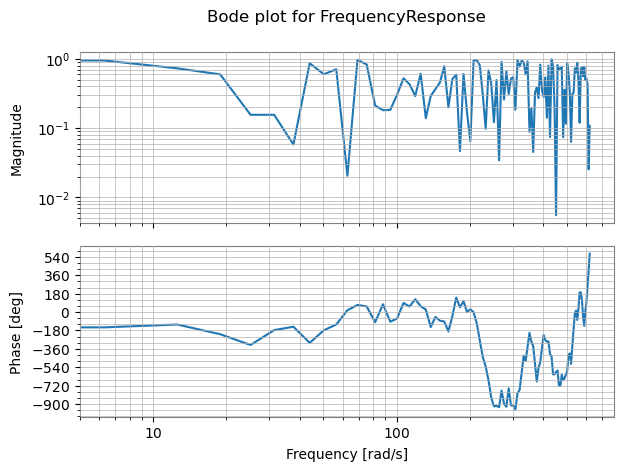

In [4]:
try:
    import control
    
    # FrequencySeries -> control.FRD 変換
    # frequency_unit="Hz" を指定すると、内部で rad/s に適切に変換して渡します
    frd_sys = fs.to_control_frd(frequency_unit="Hz")
    
    print("\n--- Converted to Control FRD ---")
    print(frd_sys)
    
    # ボード線図のプロット (controlライブラリの機能)
    control.bode(frd_sys) # (プロット環境があれば実行可能)
    
    # control.FRD -> FrequencySeries 復元
    fs_restored = FrequencySeries.from_control_frd(frd_sys, frequency_unit="Hz")
    
    print("\n--- Restored FrequencySeries ---")
    print(fs_restored)
    
except ImportError:
    print("Python Control Systems Library is not installed.")

## 4. 行列演算によるスペクトル解析

`FrequencySeriesMatrix` は行列演算をサポートしているため、チャンネル間での演算も容易です。

In [5]:
# 例: 全チャンネルの振幅スペクトル（絶対値）を計算
amp_matrix = np.abs(fsm.value)
print("\nAmplitude Matrix mean:", amp_matrix.mean())


Amplitude Matrix mean: 0.4840062332666162


## まとめ

`FrequencySeries` の拡張により、単純なスペクトル解析だけでなく、位相特性の評価、群遅延の計算、そして制御理論への応用まで、シームレスに行えるようになりました。